In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from statsmodels.tsa.arima.model import ARIMA

C:\Users\dsant\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\dsant\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\dsant\AppData\Local\Temp\ipykernel_15384\1023966090.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pmdarima.arima import auto_arima

In [3]:
# we will import the electricity production base
df = pd.read_excel('energy.xlsx', index_col='DATE', parse_dates=True)
df.head()

,energy
DATE,
1985-01-01,71.5920
1985-02-01,69.7870
1985-03-01,61.6790
1985-04-01,56.7479
1985-05-01,54.6165


In [4]:
# how many rows and columns?
df.shape

(408, 1)

In [5]:
# Descriptive statistics
df.describe()

,energy
count,408.000000
mean,88.062232
std,15.168540
min,54.616500
25%,76.499750
50%,88.940450
75%,99.733200
max,126.362600


In [6]:
# When does the data start and end?
df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00'))

In [7]:
df.columns = ['producao']

<AxesSubplot:xlabel='DATE'>

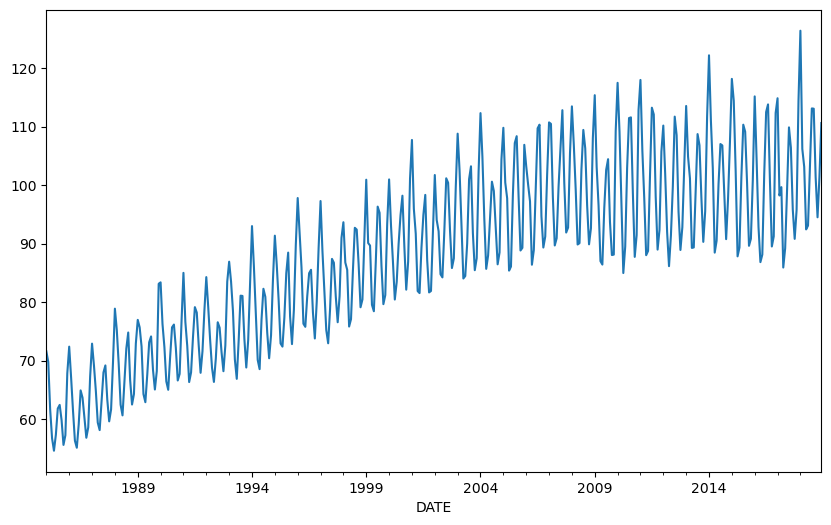

In [8]:
# Let's take a look at the graph of consumption x years
df['producao'].plot(figsize=(10,6))


<Figure size 800x600 with 0 Axes>

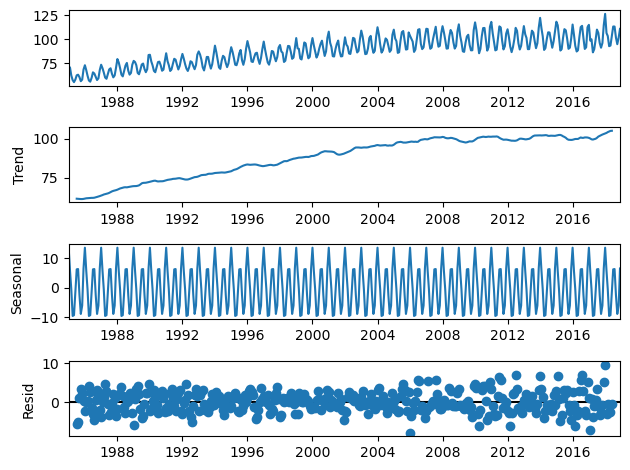

In [9]:
# First, let's decompose the series to evaluate the trend
# Seasonality and residue
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df)

fig = plt.figure(figsize=(8, 6))  
fig = resultado.plot()

In [10]:
# Stationarity test.
# The null hypothesis is that the series is not stationary
# That is, if the p-value is less than 0.05, we reject
# that the series is not stationary. If it is larger, we cannot
# rule out that the series is not stationary
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['producao'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-2.252399047046608
p-valor:0.18777984601967346


In [11]:
# Stationarity test.
# The null hypothesis is that the series is not stationary
# That is, if the p-value is less than 0.05, we reject
# that the series is not stationary. If it is larger, we cannot
# rule out that the series is not stationary
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['producao'].diff().dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-7.450892277526375
p-valor:5.674569955854434e-11


In [12]:
# Auto ARIMA helps us search for the best parameters
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=6, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, 
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1968.148, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2494.965, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=2053.701, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2128.799, Time=0.22 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2064.883, Time=0.34 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1928.298, Time=0.65 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=1868.200, Time=1.28 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=1866.400, Time=1.03 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=2014.153, Time=0.51 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=1916.488, Time=0.77 sec
 ARIMA(1,1,0)(1,1,2)[6]             : AIC=1936.850, Time=0.69 sec
 ARIMA(2,1,1)(1,1,2)[6]             : AIC=1868.120, Time=1.34 sec
 ARIMA(1,1,2)(1,1,2)[6]             : AIC=1

In [13]:
# Now that we know the best parameters, let's create a SARIMAX model
# (version of arima with parameters for seasonality)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df,order=(1,1,1),  seasonal_order=(1, 1, 2, 6))
resultado_sarimax = model.fit()

C:\Users\dsant\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dsant\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
# results of the SARIMAX(2,1,2) model
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                               producao   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 6)   Log Likelihood                -927.200
Date:                                Mon, 19 Feb 2024   AIC                           1866.400
Time:                                        09:48:37   BIC                           1890.364
Sample:                                    01-01-1985   HQIC                          1875.889
                                         - 12-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5125      0.042     12.156      0.000       0.430       0.595
ma.L1         -0.9601      0.017    -56.250      0.000      -0.994      -0.927
ar.S.L6       -0.9973      0.003   -350.064      0.000      -1.003      -0.992
ma.S.L6        0.1026      0.037      2.775      0.006       0.030       0.175
ma.S.L12      -0.7748      0.035    -22.181      0.000      -0.843      -0.706
sigma2         5.6413      0.322     17.544      0.000       5.011       6.272
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                29.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# We will carry out "backtesting" with predictions of values from the previous 12 months
predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [16]:
# confidence interval

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

C:\Users\dsant\AppData\Local\Temp\ipykernel_15384\749544226.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  limites_abaixo[0], limites_acima[0]


(115.14474798330669, 124.45517785857372)

In [17]:
predicao_media[0]

C:\Users\dsant\AppData\Local\Temp\ipykernel_15384\4088268170.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicao_media[0]


119.7999629209402

In [18]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df.index)

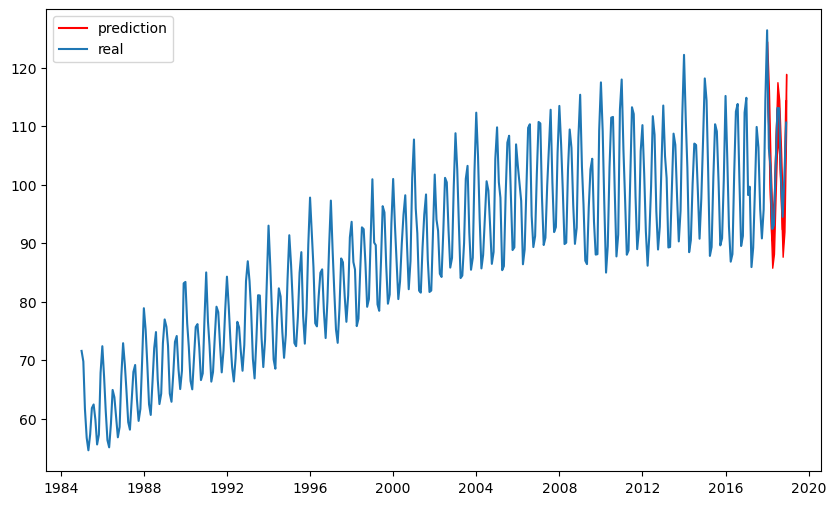

In [19]:

plt.figure(figsize=(10,6))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, df.values, label='real')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(df[-12:].values,predicao_media.values))
print(rmse_sarima)

3.426278938624038


## FORECAST WITH ARIMA

In [21]:
# Forecast pra 12 values

forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

12

In [22]:

intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[10], intervalo_acima_f[10]

C:\Users\dsant\AppData\Local\Temp\ipykernel_15384\1761406962.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intervalo_abaixo_f[10], intervalo_acima_f[10]


(91.38813142795122, 103.10930757058817)

In [23]:
forecast_medio[10]

C:\Users\dsant\AppData\Local\Temp\ipykernel_15384\459763208.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_medio[10]


97.2487194992697

In [24]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

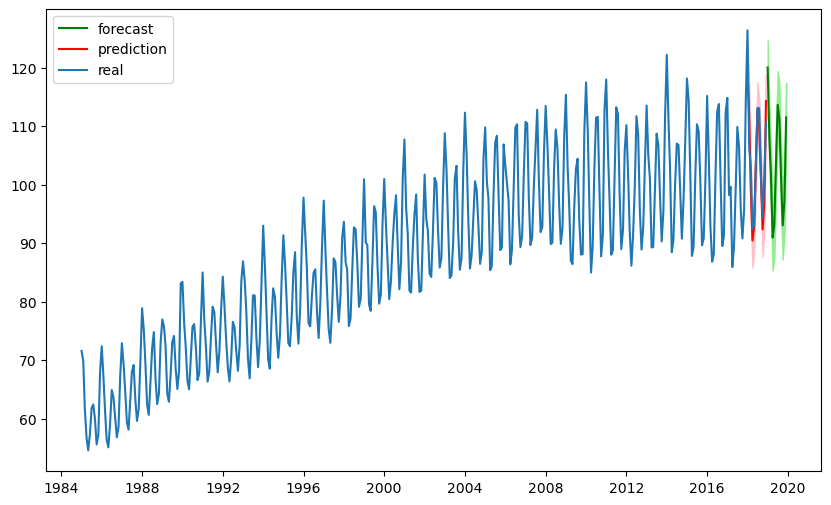

In [25]:

dates=np.asarray(df.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates,df.values, label='real')
plt.legend(loc='upper left')
plt.show()

In [26]:
from xgboost import XGBRegressor

In [28]:
train = df.loc[df.index < "2016-12-31"]
validation = df.loc[df.index > "2016-12-31"]

train.shape, validation.shape

((384, 1), (24, 1))

In [29]:
train.head()

,producao
DATE,
1985-01-01,71.5920
1985-02-01,69.7870
1985-03-01,61.6790
1985-04-01,56.7479
1985-05-01,54.6165


In [30]:
train["target"] = train["producao"].shift(-1)
train.head()

C:\Users\dsant\AppData\Local\Temp\ipykernel_15384\3676281312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["target"] = train["producao"].shift(-1)


,producao,target
DATE,,
1985-01-01,71.5920,69.7870
1985-02-01,69.7870,61.6790
1985-03-01,61.6790,56.7479
1985-04-01,56.7479,54.6165
1985-05-01,54.6165,57.3509


In [31]:
train.dropna(inplace=True)

C:\Users\dsant\AppData\Local\Temp\ipykernel_15384\167719433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)


In [32]:
validation["target"] = validation["producao"].shift(-1)
validation.head()

C:\Users\dsant\AppData\Local\Temp\ipykernel_15384\349151612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation["target"] = validation["producao"].shift(-1)


,producao,target
DATE,,
2017-01-01,114.8282,98.2191
2017-02-01,98.2191,99.6408
2017-03-01,99.6408,85.9106
2017-04-01,85.9106,89.2053
2017-05-01,89.2053,99.1945


In [33]:
validation.dropna(inplace=True)

C:\Users\dsant\AppData\Local\Temp\ipykernel_15384\2326254463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.dropna(inplace=True)


In [34]:
x_train = train.loc[:, ["producao"]].values
y_train = train.loc[:, ["target"]].values
x_validation = validation.loc[:, ["producao"]].values
y_validation = validation.loc[:, ["target"]].values

In [36]:
modelo_xgba = XGBRegressor()
modelo_xgba.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [37]:
validation.iloc[0]

producao    114.8282
target       98.2191
Name: 2017-01-01 00:00:00, dtype: float64

In [42]:
predict = modelo_xgba.predict(x_validation)
predict

array([103.86972 , 102.7595  , 109.48729 ,  78.83086 ,  92.39584 ,
        92.556015, 101.47449 , 110.37736 ,  95.53983 ,  99.24283 ,
        95.53983 , 102.701965, 111.40189 ,  98.29675 ,  96.66097 ,
        90.28177 ,  87.64868 ,  99.88448 , 111.89654 , 111.89654 ,
       111.14365 ,  97.18245 , 111.14365 ], dtype=float32)

In [43]:
validation["pred"] = predict
validation.head()

C:\Users\dsant\AppData\Local\Temp\ipykernel_15384\2464795971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation["pred"] = predict


,producao,target,pred
DATE,,,
2017-01-01,114.8282,98.2191,103.869720
2017-02-01,98.2191,99.6408,102.759499
2017-03-01,99.6408,85.9106,109.487289
2017-04-01,85.9106,89.2053,78.830856
2017-05-01,89.2053,99.1945,92.395844


In [44]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(x_validation, predict)

6.086205224078634